In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict CAD/JPY exchange rate returns with *lagged* CAD/JPY exchange rate returns. 

In [22]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [23]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Data Preparation

### Returns

In [24]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:

cad_jpy_df['Return'] = (cad_jpy_df.Price.pct_change() * 100).copy()
yen_futures = cad_jpy_df.replace(-np.inf, np.nan).dropna()
yen_futures.tail()

,Price,Open,High,Low,Return
Date,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697
2020-06-01,79.27,78.21,79.36,78.04,1.251756
2020-06-02,80.40,79.26,80.56,79.15,1.425508
2020-06-03,80.70,80.40,80.82,79.96,0.373134
2020-06-04,80.71,80.80,80.89,80.51,0.012392


### Lagged Returns 

In [25]:
# Create a lagged return using the shift function
yen_futures['Lagged_Return'] = yen_futures.Return.shift()
yen_futures = yen_futures.dropna()
yen_futures.tail()

,Price,Open,High,Low,Return,Lagged_Return
Date,,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697,-0.114913
2020-06-01,79.27,78.21,79.36,78.04,1.251756,0.076697
2020-06-02,80.40,79.26,80.56,79.15,1.425508,1.251756
2020-06-03,80.70,80.40,80.82,79.96,0.373134,1.425508
2020-06-04,80.71,80.80,80.89,80.51,0.012392,0.373134


### Train Test Split

In [26]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2018']
test = yen_futures['2018':]

In [27]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [28]:
X_train

,Lagged_Return
Date,
1990-01-04,-0.846720
1990-01-05,-1.468476
1990-01-08,0.874777
1990-01-09,-0.216798
1990-01-10,0.667901
1990-01-11,0.567546
1990-01-12,0.031794
1990-01-15,0.119190
1990-01-16,-0.619048


# Linear Regression Model

In [29]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [30]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [31]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

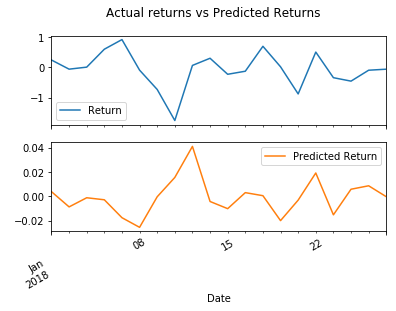

In [32]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True, title = "Actual returns vs Predicted Returns")
plt.savefig("Images/predictions_vs_actual.png")

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [15]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 

mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")



Out-of-Sample Root Mean Squared Error (RMSE): 0.6445828596930245


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [16]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that DataFrame:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.8342483222052092


# Conclusions

When comparing RMSE betwen out-of-sample and in-sample performance, the RMSE for in-sample performance is expected to be lower than out-of-sample performance data, but in this case the out-of-sample RMSE (0.64) is lower than the in-sample RMSE (0.83). 
No I will not feel confident using these models for trading.
